In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

!pip install optuna
import optuna

# ignoring the warnings while executing codes
import warnings
warnings.filterwarnings("ignore")

# importing custom matplotlib parameters for visualizations
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["font.family"] = "monospace"

# Color Palettes
colors = ["#bfd3e6", "#9b5b4f", "#4e4151", "#dbba78", "#bb9c55", "#909195","#dc1e1e","#a02933","#716807","#717cb4"]

In [ ]:

# importing Dataset
house = pd.read_csv(r"train.csv")
house_test = pd.read_csv(r"test.csv")

# checking dataset
house.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#describe the data with some visual style by applying T = Transpose and style
house.describe().T.style.bar(subset=['mean'],color=colors[3]).background_gradient(subset=['std','50%','max'])

,count,mean,std,min,25%,50%,75%,max
Id,1460.000000,730.500000,421.610009,1.000000,365.750000,730.500000,1095.250000,1460.000000
MSSubClass,1460.000000,56.897260,42.300571,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,1201.000000,70.049958,24.284752,21.000000,59.000000,69.000000,80.000000,313.000000
LotArea,1460.000000,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.000000
OverallQual,1460.000000,6.099315,1.382997,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,1460.000000,5.575342,1.112799,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,1460.000000,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000
YearRemodAdd,1460.000000,1984.865753,20.645407,1950.000000,1967.000000,1994.000000,2004.000000,2010.000000
MasVnrArea,1452.000000,103.685262,181.066207,0.000000,0.000000,0.000000,166.000000,1600.000000
BsmtFinSF1,1460.000000,443.639726,456.098091,0.000000,0.000000,383.500000,712.250000,5644.000000



<div class="intro2">
    📌 Summary <br>
    <br> ‣ We imported the dataset <br> ‣ we also looked at info where we found out that there are 3 types of datatypes float64(3), int64(35), object(43)
    <br> ‣ we also saw the stats of data.

<div class="section" > Target Variable

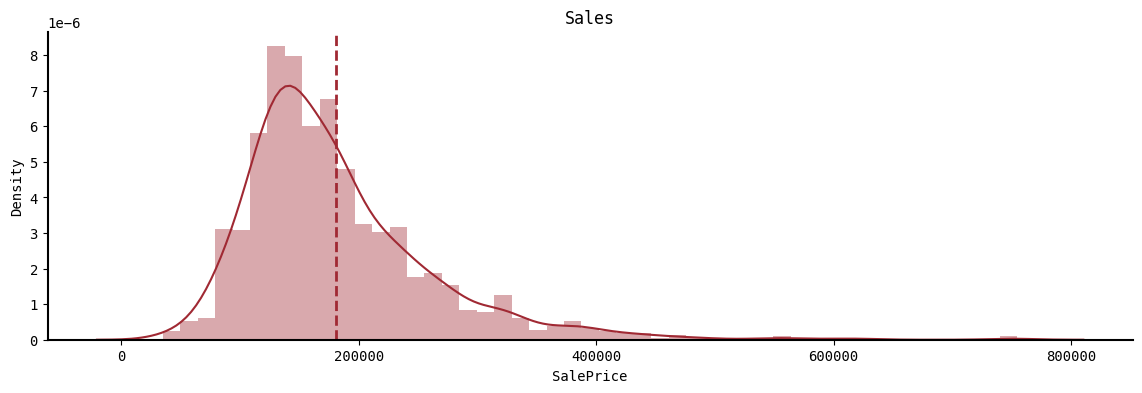

In [ ]:
#checking the target variables for distribution
sns.distplot(house['SalePrice'],color=colors[7])
plt.axvline(x=house['SalePrice'].mean(), color=colors[7], linestyle='--', linewidth=2)
plt.title('Sales');

<div class="section" id = "title">Missing Values

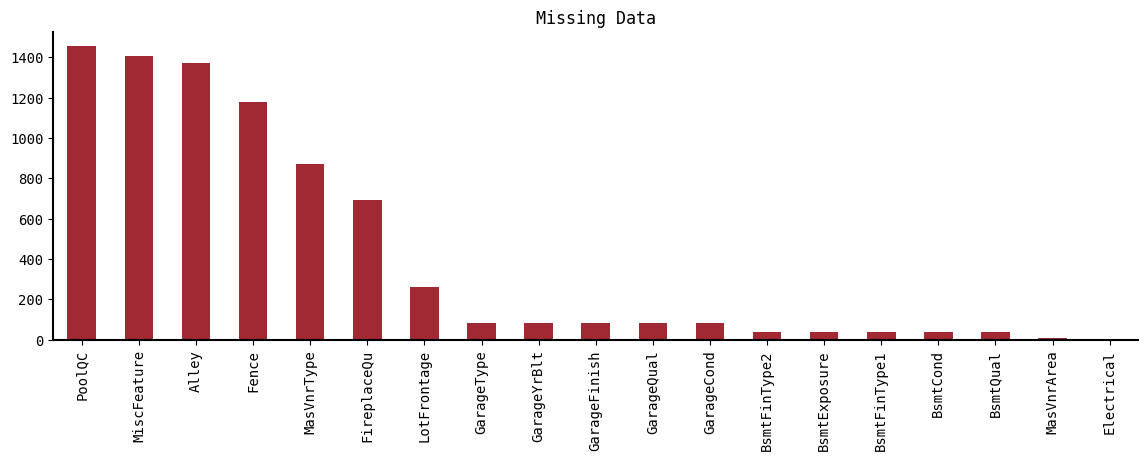

In [ ]:
#checking missing values
missing = house.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing.plot.bar(color=colors[7])
plt.title('Missing Data');

<div class="intro2">‣ We can see that some of data got more than 50% missing data which is not good for training model.<br> ‣ I will drop those values and for those who are less than 50% we will try to fill them.

<div class="section" id = "title">Corelation

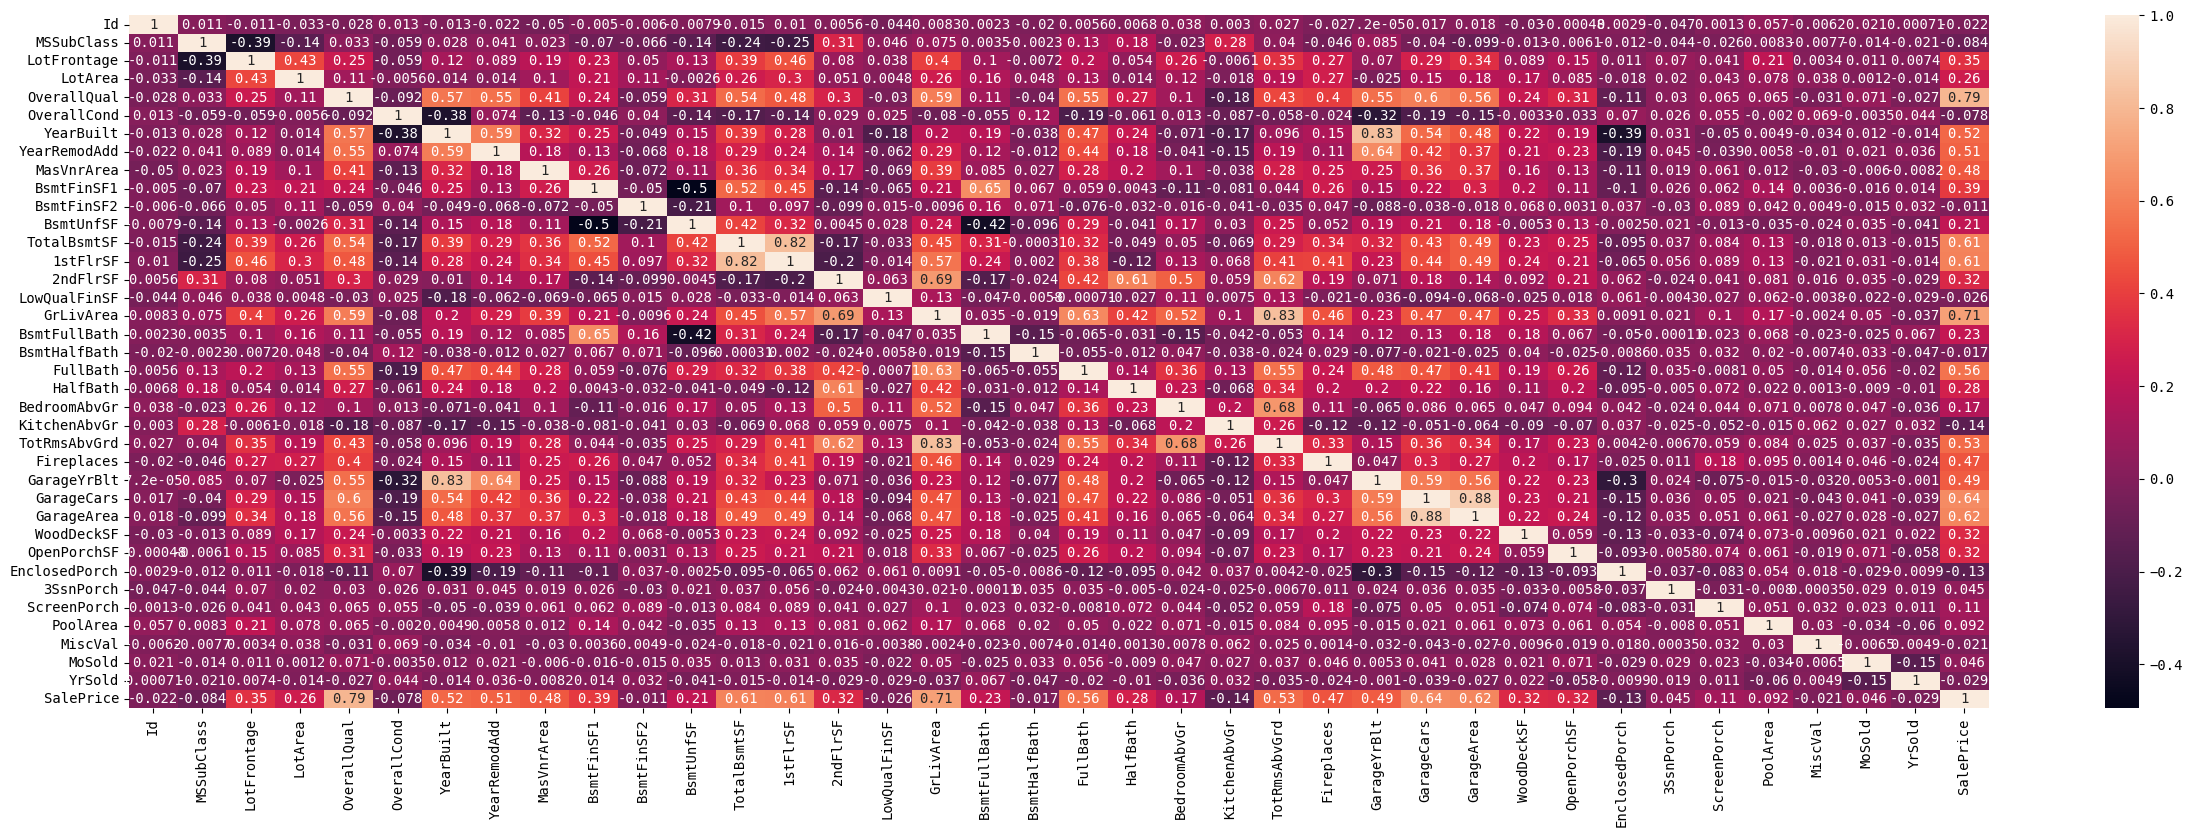

In [ ]:
# Filter out non-numeric columns
numeric_columns = house.select_dtypes(include=np.number)

# Plot the heatmap
plt.figure(figsize=(30, 9))
sns.heatmap(numeric_columns.corr(), annot=True)
plt.show()


<div class="section" id = "title">Pre Processing</div>

In [ ]:
# droping values more than 50%

y = house['SalePrice']
house = house.drop(['Id','Alley','PoolQC','Fence','MiscFeature','SalePrice'],axis=1)
house_test = house_test.drop(['Id','Alley','PoolQC','Fence','MiscFeature'],axis=1)

In [ ]:
num_cols = [col for col in house.columns if house[col].dtype in ['float64','int64']]
cat_cols = [col for col in house.columns if house[col].dtype not in ['float64','int64']]

In [ ]:

house[num_cols] = SimpleImputer().fit_transform(house[num_cols])
house_test[num_cols] = SimpleImputer().fit_transform(house_test[num_cols])

house[num_cols] = MinMaxScaler().fit_transform(house[num_cols])
house_test[num_cols] = MinMaxScaler().fit_transform(house_test[num_cols])

In [ ]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond',
                'MasVnrType','Electrical','MSZoning','Utilities','Functional','Exterior2nd','KitchenQual','Exterior1st','SaleType']
house[columns_None] = house[columns_None].fillna('none')
house_test[columns_None] = house_test[columns_None].fillna('none')

In [ ]:
# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(house[cat_cols])
encoded_cols = encoder.get_feature_names_out(cat_cols)  # Use get_feature_names_out for scikit-learn >= 1.0
house[encoded_cols] = encoder.transform(house[cat_cols])


In [ ]:
house_test[encoded_cols] = encoder.transform(house_test[cat_cols])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Create training and validation sets
house.columns
for col in encoded_cols:
    if col not in house.columns:
        print(f"{col} not in DataFrame")
encoded_cols = [col for col in encoded_cols if col in house.columns]
#encoded_cols = ["MasVnrType_None", "MasVnrType_BrkFace", "MasVnrType_Stone"]
X_train,X_test,y_train,y_test = train_test_split(house[num_cols + encoded_cols],
                                                 y,
                                                 test_size=0.25,
                                                 random_state=42)

<div class="section" id = "title">Regression Models</div>

In [ ]:
#making dictionary of models
models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor()
}

In [ ]:
#taking results from the models
model_results = []
model_names = []

# training the model with function
for name,model in models.items():
    a = model.fit(X_train,y_train)
    predicted = a.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, predicted))
    model_results.append(score)
    model_names.append(name)

    #creating dataframe
    df_results = pd.DataFrame([model_names,model_results])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'RMSE'}).sort_values(by='RMSE',ascending=False)

print(df_results)

                   Model                  RMSE
6       LinearRegression  219798858895680.3125
0                    SVR          84754.172435
3             ElasticNet          49514.228967
4           SGDRegressor          30975.911609
5          BayesianRidge          29419.317562
2                  Ridge          28593.593005
7  RandomForestRegressor          27059.548305
1           XGBRegressor          26164.874024


<div class="intro2">‣ We tried multiple models but the best model was with lowest RMSE "XGB Regressor".
    <br>‣ Now the question arise how we can further reduce the error? we can reduce it by using hyper parameter tuning, but how to decide ? how to guess the best parameters?
    ‣ Lets do it in our next step.

# <center> <span style="font-family:Playfair Display"> <span style="color:white;display:fill;border-radius:8px;background-color:#a02933;font-size:100%;font-weight: bold;color: #dbba78;font-style: italic;">ㅤHyper Parameter Tuningㅤ</span><a id="1"></a>

<div class="section" id = "title">Optuna

‣ Optuna is the framework for tuning prameters. you can read more about optuna <a href="https://optuna.org/" rel=" noreferrer nofollow">here.</a>

In [ ]:
best_params = {'lambda': 3.559040735218393,
 'alpha': 0.25772549522868987,
 'colsample_bytree': 0.6,
 'subsample': 0.5,
 'learning_rate': 0.014,
 'n_estimators': 4000,
 'max_depth': 11,
 'random_state': 24,
 'min_child_weight': 3}

In [ ]:
XGBR = XGBRegressor(booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=0.6,
                    gamma=0,
                    importance_type='gain',
                    learning_rate=0.01,
                    max_delta_step=0,
                    max_depth=4,
                    min_child_weight=1.5,
                    n_estimators=2400,
                    n_jobs=1,
                    nthread=None,
                    objective='reg:linear',
                    reg_alpha=0.6,
                    reg_lambda=0.6,
                    scale_pos_weight=1,
                    silent=None,
                    subsample=0.8,
                    verbosity=1)

XGBR.fit(X_train,y_train)
predicted = XGBR.predict(X_test)
print(f'Root Mean Square Error test = {mean_squared_error(y_test, predicted,squared=False)}')

Root Mean Square Error test = 23060.046382228065


# <center> <span style="font-family:Playfair Display"> <span style="color:white;display:fill;border-radius:8px;background-color:#a02933;font-size:100%;font-weight: bold;color: #dbba78;font-style: italic;">ㅤ📦 Submissionㅤ</span><a id="1"></a>

In [ ]:
test_preds = XGBR.predict(house_test[num_cols + encoded_cols])

In [ ]:
submission_df = pd.read_csv("sample_submission.csv")
submission_df['SalePrice'] = test_preds
submission_df.to_csv('finalSubmission.csv', index=False)

# <center> <span style="font-family:Playfair Display"> <span style="color:white;display:fill;border-radius:8px;background-color:#a02933;font-size:100%;font-weight: bold;color: #dbba78;font-style: italic;">ㅤTHE ENDㅤ</span><a id="1"></a>